In [33]:
%matplotlib inline

In [34]:
import matplotlib.pyplot as plt

import screed
from collections import defaultdict

import importlib
import alignplot
import pprint
importlib.reload(alignplot)

from alignplot import StackedDotPlot

## another tara genome, this time with two contaminants

In [35]:
if 0:
    dotplot = StackedDotPlot('TARA_PSE_MAG_00132', ('GCA_001550135.1', 'GCA_001641615.1'), 'list.csv', './genomes')
    #dotplot.use_mashmap = True
    x = dotplot()

In [36]:
if 0:
    dotplot = StackedDotPlot('TARA_ANW_MAG_00083', ('GCA_002171995.1',), 'list.csv', './genomes')
    dotplot = StackedDotPlot('GCA_002171995.1', ('TARA_ANW_MAG_00083',), 'list.csv', './genomes')

    dotplot.use_mashmap = True
    x = dotplot()

In [37]:
if 0:
    dotplot = StackedDotPlot('GCA_001550135.1', ('TARA_PSE_MAG_00132', 'GCA_001641615.1'), 'list.csv', './genomes')
    #dotplot.use_mashmap = True
    x = dotplot()

['./genomes/GCA_003220225.1_ASM322022v1_genomic.fna']
found queryfile for GCA_003220225.1: ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna
found targetfile for GCA_003222275.1: ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna
running nucmer & show-coords for ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna...
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpc5iorut4.
shared w/Acidobacteria bacterium: 635.4kb
['./genomes/GCA_003222275.1_ASM322227v1_genomic.fna']
found queryfile for GCA_003222275.1: ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna
found targetfile for GCA_003220225.1: ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna
running nucmer & show-coords for ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna...
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmp55yqnrwj.
shared w/Candidatus Rokubacteria bacterium: 640.9kb


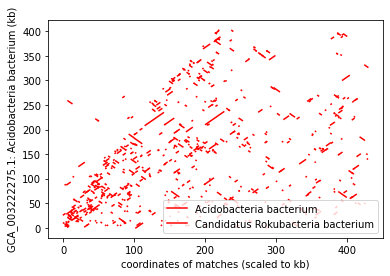

In [42]:
if 1:
    dotplot = StackedDotPlot('GCA_003220225.1',
                             ['GCA_003222275.1',],
                             'list.csv', './genomes')
    _ = dotplot()
    
if 1:
    dotplot2 = StackedDotPlot('GCA_003222275.1',
                             ['GCA_003220225.1'],
                             'list.csv', './genomes')
    _ = dotplot2()

In [39]:
#dotplot = StackedDotPlot('GCA_003222275.1',
#                         ['GCA_003222275.1',],
#                         'list.csv', './genomes')
#_ = dotplot()

In [48]:
def investigate_regions(dotplot, t_acc):
    regions = dotplot.results[t_acc]
    targetfile = None
    for find_t_acc, find_targetfile in zip(dotplot.t_acc_list, dotplot.targetfiles):
        if find_t_acc == t_acc:
            targetfile = find_targetfile
            
    assert targetfile

    sorted_regions = []
    kb_above_95 = 0
    for region in regions:
        pident = region.pident
        fident = pident / 100
        f_match = abs(region.tend - region.tstart) / region.tsize
        contig_ani = f_match * fident
        sorted_regions.append((contig_ani, f_match, region))
        
        if pident >= 95:
            kb_above_95 += abs(region.tend - region.tstart)

    sorted_regions.sort(reverse=True)


    sum_bp = 0
    all_sizes = {}
    for record in screed.open(targetfile):
        sum_bp += len(record.sequence)
        all_sizes[record.name.split()[0]] = len(record.sequence) / 1e3

    regions_by_target = defaultdict(list)
    for region in regions:
        x = regions_by_target[region.target]
        x.append(region)
        regions_by_target[region.target] = x

    x = []
    y = []
    sofar = 0
    ani_sofar = 0
    seen = set()
    for (_, _, region) in sorted_regions:
        if region.target in seen:
            continue
            
        seen.add(region.target)
        for region2 in regions_by_target[region.target]:
            if region2.pident >= 95:
                ani_sofar += abs(region.tend - region.tstart)
        
        sofar += all_sizes[region.target]
        assert all_sizes[region.target] > 0
        x.append(sofar)
        y.append(ani_sofar)
        
    remaining_names = set(all_sizes) - seen
    for contig in remaining_names:
        sofar += all_sizes[contig]
        x.append(sofar)
        y.append(ani_sofar)
           
    return x, y

t_acc = dotplot.t_acc_list[0]
x, y = investigate_regions(dotplot, t_acc)

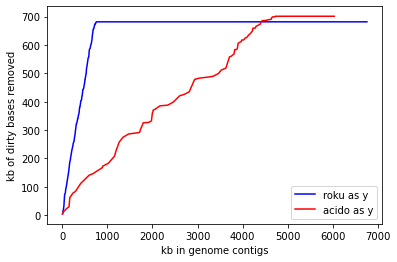

In [54]:
# convert to fractions
# worry about duplicate bad kb
t_acc = dotplot.t_acc_list[0]
x, y = investigate_regions(dotplot, t_acc)

t_acc = dotplot2.t_acc_list[0]
x2, y2 = investigate_regions(dotplot2, t_acc)

plt.plot(x, y, 'b-', label='roku as y')
plt.plot(x2, y2, 'r-', label='acido as y')

plt.xlabel('kb in genome contigs')
plt.ylabel('kb of dirty bases removed')
plt.legend(loc='lower right')
plt.savefig('/tmp/acido-target.png')